In [1]:
# загрузка необходимых пакетов
!pip install keras_vggface
!pip install livelossplot
!pip install keras_applications --no-deps

  Using cached keras_vggface-0.6-py3-none-any.whl (8.3 kB)
  Using cached Keras_Applications-1.0.8-py3-none-any.whl (50 kB)


In [3]:
# устранение ошибки загрузки
filename = "c:/users/engen/anaconda3/lib/site-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))

20951

In [5]:
import numpy as np
import tensorflow as tf
import pandas as pd
from pathlib import Path
import time
import csv

from tensorflow import keras
from livelossplot.tf_keras import PlotLossesCallback
from keras_vggface.vggface import VGGFace

import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

from keras_vggface import utils
from keras_vggface.utils import preprocess_input as preprocess_input_vggface

# вывод графика и сохранение в ноутбуке
%matplotlib inline

In [ ]:
# версия tensorflow
tf.__version__

'2.6.4'

In [6]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
N_CLASSES = 9

In [7]:
# загрузка обученной модели VGGFace
vggface_model = VGGFace(model='resnet50', include_top=False,
                        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
                        )
vggface_model.summary()

94694792/94694792 [==============================] - 1s 0us/step
Model: "vggface_resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 112, 112, 64  9408        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 112, 112, 64  256        ['conv1/7x7_s2[0][0]']           
 ation)           

In [17]:
# создание модели с дополнительными слоями для решения моей задачи
model = tf.keras.Sequential([
    vggface_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(N_CLASSES)])
model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vggface_resnet50 (Functiona  (None, 1, 1, 2048)       23561152  
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 9)                 4617      
                                                                 
Total params: 24,614,857
Trainable params: 24,561,737
Non-trainable params: 53,120
_______________________________________

In [14]:
# загрузка обучающего и валидационного датафреймов из csv-файлов
train_df = pd.read_csv('train_df.csv', index_col = 0) 
test_df = pd.read_csv('test_df.csv', index_col = 0)

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40037 entries, 46357 to 14269
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  40037 non-null  object
 1   emotion     40037 non-null  object
dtypes: object(2)
memory usage: 938.4+ KB


In [16]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10009 entries, 2 to 50040
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  10009 non-null  object
 1   emotion     10009 non-null  object
dtypes: object(2)
memory usage: 234.6+ KB


In [ ]:
# функция препроцессинга 
def preprocess_input_facenet(image_):
    """
    image_ -- тензор размера (1, H, W, 3)
    return: картинка, с примененным preprocess_input(..., version=2) из keras_vggface
    """
    preprocessed = utils.preprocess_input(image_, version=2)
    
    return preprocessed

In [ ]:
# генератор обучающих данных с функцией аугментации
train_generator = ImageDataGenerator(
                                     rotation_range=15,
                                     horizontal_flip=True,
                                     fill_mode='nearest',
                                     brightness_range=(0.5,1.5),
                                     shear_range=0.1,
                                     zoom_range=.1,
                                     preprocessing_function=preprocess_input_facenet)
        
train_data_gen = train_generator.flow_from_dataframe(dataframe=train_df,
                                                     x_col='image_path',
                                                     y_col='emotion',
                                                     target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                     batch_size=BATCH_SIZE,
                                                     class_mode='sparse',
                                                     shuffle=True,
                                                     interpolation='nearest',
                                                )

# генератор валидационных данных
val_generator = ImageDataGenerator(preprocessing_function=preprocess_input_facenet)

val_data_gen = val_generator.flow_from_dataframe(dataframe=test_df,
                                                 x_col='image_path',
                                                 y_col='emotion',
                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='sparse',
                                                 shuffle=False,
                                                 interpolation='nearest',
                                                )

Found 40037 validated image filenames belonging to 9 classes.
Found 10009 validated image filenames belonging to 9 classes.


In [ ]:
# создание папки модели и имени файла для записи весов во время обучения
path = Path('model_vggface_resnet50')
path.mkdir(exist_ok=True, parents=True) # папка создается на диске вместе с "родителями"
assert path.exists()
cpt_filename = 'best_checkpoint.hdf5'  
cpt_path = str(path / cpt_filename)

In [ ]:
# обратный вызов для сохранения весов модели
checkpoint = ModelCheckpoint(cpt_path,
                            verbose=1,
                            save_best_only=True,
                            save_weights_only=True,
                            save_freq='epoch',
                            mode='min')

In [ ]:
# функция экспоненциального затухания к шагу оптимизатора с заданной начальной скоростью обучения
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-4,
    decay_steps=100,
    decay_rate=0.9)

# настройка модели для обучения
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

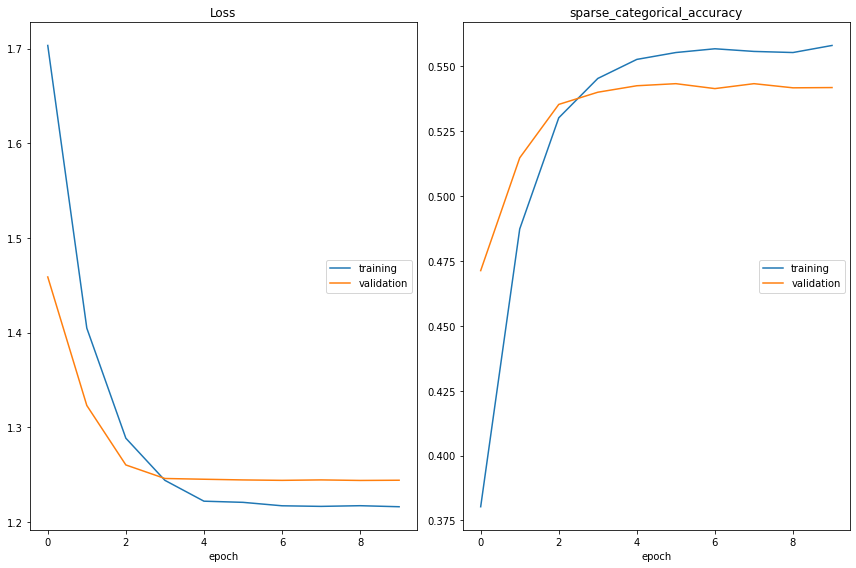

Loss
	training         	 (min:    1.216, max:    1.703, cur:    1.216)
	validation       	 (min:    1.244, max:    1.459, cur:    1.244)
sparse_categorical_accuracy
	training         	 (min:    0.380, max:    0.558, cur:    0.558)
	validation       	 (min:    0.471, max:    0.543, cur:    0.542)


In [ ]:
# обучение модели
EPOCHS = 10
history = model.fit(train_data_gen, epochs=EPOCHS, validation_data=val_data_gen,
                    callbacks=[checkpoint,
                               PlotLossesCallback()
                              ]
                    )

In [ ]:
# значение потерь и значения метрики для модели в тестовом режиме
model.evaluate(val_data_gen)

313/313 [==============================] - 78s 250ms/step - loss: 1.2439 - sparse_categorical_accuracy: 0.5418


[1.2438523769378662, 0.5418123602867126]

In [23]:
# запись весов модели
model.save_weights('model_vggface_resnet50/weights.h5')

In [22]:
# запись конфигурации модели
model_json = model.to_json()
with open("model_vggface_resnet50/model.json","w") as json_file:
    json_file.write(model_json)

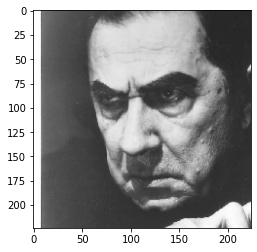

In [ ]:
# случайный выбор и обработка изображения для теста
rng = np.random.default_rng()
n = rng.integers(5000, size=1)[0]
img = image.load_img('test_kaggle/' + str(n) + '.jpg', target_size=(IMAGE_SIZE, IMAGE_SIZE))
x = image.img_to_array(img, dtype=np.float64)
x = np.expand_dims(x, axis=0)
plt.imshow(img)

In [ ]:
# определение времени инференса сети
%%timeit 
# -n 10 -r 10

model.predict(preprocess_input_facenet(x))

43.3 ms ± 3.87 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
# создание словаря эмоций из файла
def load_dict_from_file(path):
    f = open(path,'r')
    data=f.read()
    f.close()
    return eval(data)

emotion_mapping = load_dict_from_file('dict.txt')
emotion_mapping

{0: 'anger',
 1: 'contempt',
 2: 'disgust',
 3: 'fear',
 4: 'happy',
 5: 'neutral',
 6: 'sad',
 7: 'surprise',
 8: 'uncertain'}

In [ ]:
# определение эмоции на тестовом изображении
predicted = model.predict(preprocess_input_facenet(x))
emotion_mapping[np.argmax(predicted)]

'anger'

In [26]:
# создание списка для структруированного по заданию итогового csv-файла из файла 
def load_list_from_file(path):
    f = open(path,'r')
    data=f.read()
    f.close()
    return eval(data)

my_list = load_list_from_file('test_list.txt')   

In [ ]:
# запись итогового csv-файла
with open('submission_vggface.csv', 'w') as f:
    fieldnames = ['image_path', 'emotion']
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    for name in my_list:
        img = image.load_img('test_kaggle/'+ name, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        predicted_arr = model.predict(preprocess_input_facenet(x))
        predicted = emotion_mapping[np.argmax(predicted_arr)]
        writer.writerow({'image_path': name.replace('test_kaggle/', ''), 'emotion': predicted})

### Оценки Kaggle

Score: 0,53000

Public Score:  0,54040